In [1]:
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

# Variables / Hyperparameters

In [2]:
IMG_HEIGHT = 128
TRAIN_SIZE = 0.8
RANDOM_STATE = 42
BATCH_SIZE = 32
LR = 0.001

## Load Data/Images 

In [3]:
LABELS_PATH = "./ml2024-datasets/sign_lang_train/labels.csv"
IMAGES_PATH = "./ml2024-datasets/sign_lang_train/"

In [4]:
from sklearn.model_selection import train_test_split
img_label = pd.read_csv(LABELS_PATH)

# Insights about the Data
### Number of Elements that belong to each Class

In [5]:
# get classes
classes = img_label["label"].unique()
classes_cups = {cls:0 for cls in classes}

for _, row in img_label.iterrows():
    classes_cups[row[0]] += 1

class_values = classes_cups.values()
num_classes = len(classes)
print("Number of different classes:", num_classes)

Number of different classes: 36


In [6]:
### matplotlib setup
import matplotlib.colors as mcolors
# get color names
colors = mcolors.CSS4_COLORS
color_names = list(colors.keys())[:num_classes]

# set style
plt.style.use("fivethirtyeight")


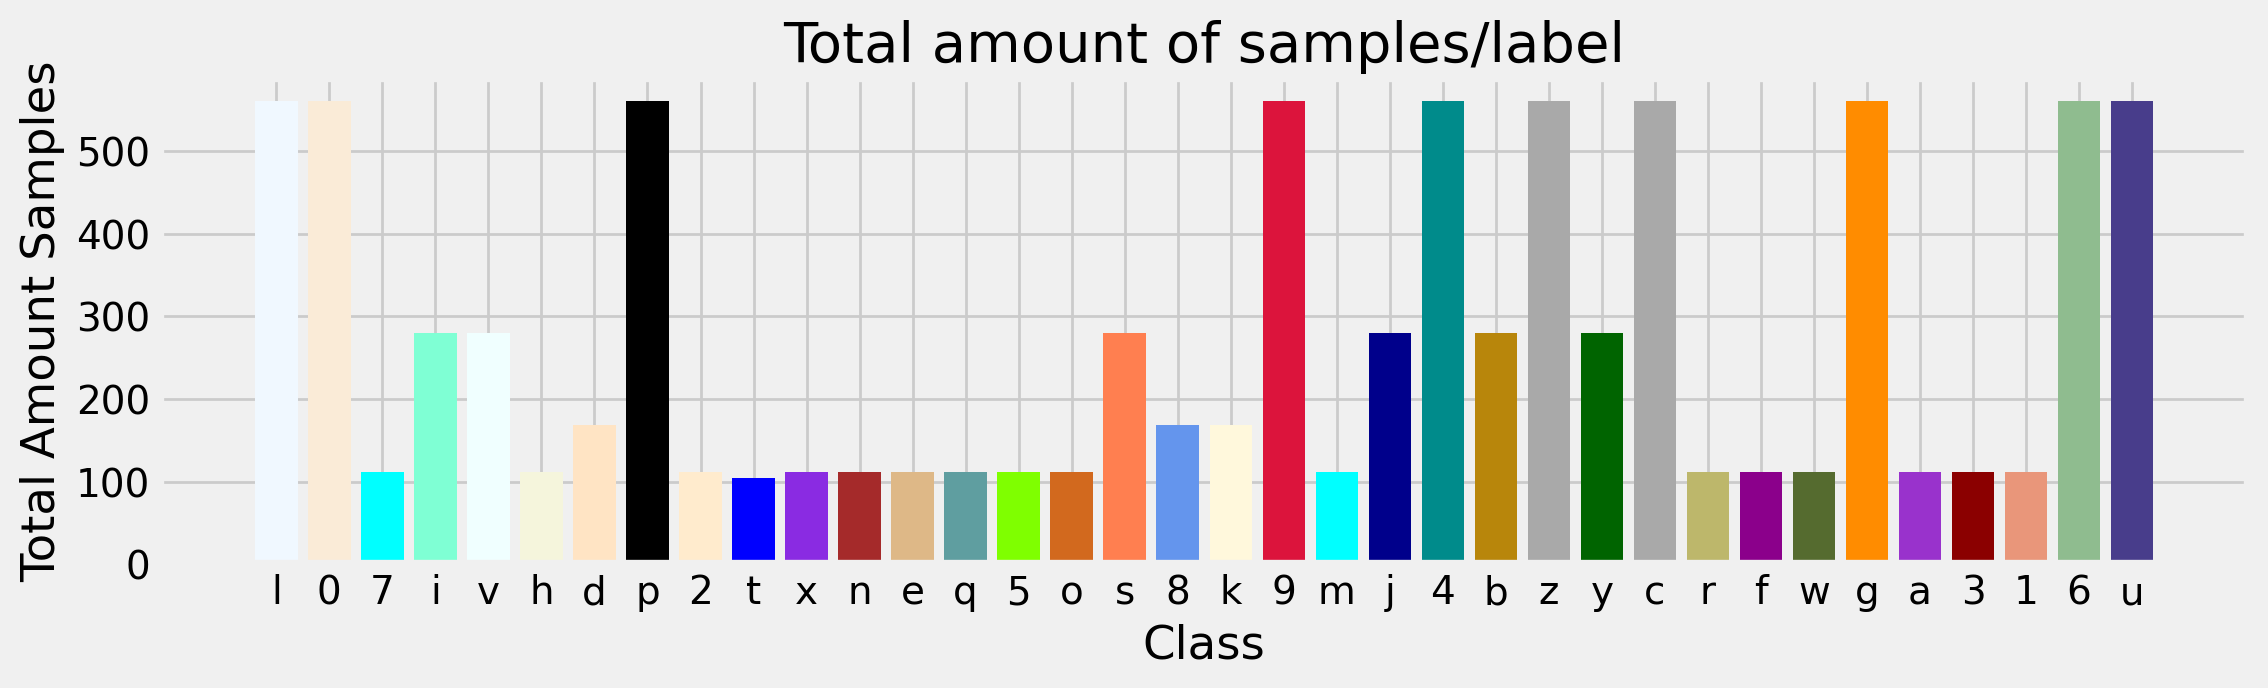

In [7]:
plt.figure(figsize=(12, 3), dpi=200)
plt.title("Total amount of samples/label")
plt.xlabel("Class")
plt.ylabel("Total Amount Samples")
plt.bar(range(num_classes), class_values, tick_label = classes, color=color_names)
plt.show()

In [8]:
from preprocessing.dataset import SignLanguageDataset

# Create Train/Test Split

In [9]:
from preprocessing.utils import filter_by_label
# split labels into train & test 
train_labels, test_labels = train_test_split(img_label, train_size=TRAIN_SIZE, stratify=img_label["label"], random_state=RANDOM_STATE)

# for each label, generate a dataframe holding only information about this specific label
train_labels_indiv = {l: filter_by_label(l, train_labels) for l in classes}

In [10]:
from preprocessing.utils import default_transform, augmented_transform, rotate_transform
from torch.utils.data import ConcatDataset

# defines the threshold from which the labels should be augmented
threshold = 300
labels_to_augment = {l: train_labels_indiv[l] for l in train_labels_indiv.keys() if classes_cups[l] < threshold}
labels_not_to_augment = {l: train_labels_indiv[l] for l in train_labels_indiv.keys() if classes_cups[l] >= threshold}

aug_datasets = []
non_aug_datasets = []
def_transform = default_transform(IMG_HEIGHT, IMG_HEIGHT)
aug_transform = augmented_transform(IMG_HEIGHT, IMG_HEIGHT)

# handle aug labels
for l in labels_to_augment.keys():
    aug_ds = SignLanguageDataset(annotations=labels_to_augment[l], transform=aug_transform, img_dir=IMAGES_PATH)
    aug_datasets.append(aug_ds)
    # aug_ds_rotate = SignLanguageDataset(annotations=labels_to_augment[l], transform=rotate_transform(IMG_HEIGHT, IMG_HEIGHT), img_dir=IMAGES_PATH)
    # aug_datasets.append(aug_ds_rotate)
    
# still keep whole "normal dataset"
for l in train_labels_indiv.keys():
    ds = SignLanguageDataset(annotations=train_labels_indiv[l], transform=def_transform, img_dir=IMAGES_PATH)
    non_aug_datasets.append(ds)
    
aug_datasets = []
concat_datasets = non_aug_datasets + aug_datasets
no_aug_dataset = ConcatDataset(non_aug_datasets)
train_dataset = ConcatDataset(concat_datasets)

In [11]:
# display distribution of augmented dataset
classes_aug_cups = {l: 0 for l in classes}
classes_naug_cups = {l: 0 for l in classes}

for i in range(len(train_dataset)):
    label = train_dataset[i][1]
    classes_aug_cups[label] += 1
 
for i in range(len(no_aug_dataset)):
	label = no_aug_dataset[i][1]
	classes_naug_cups[label] += 1

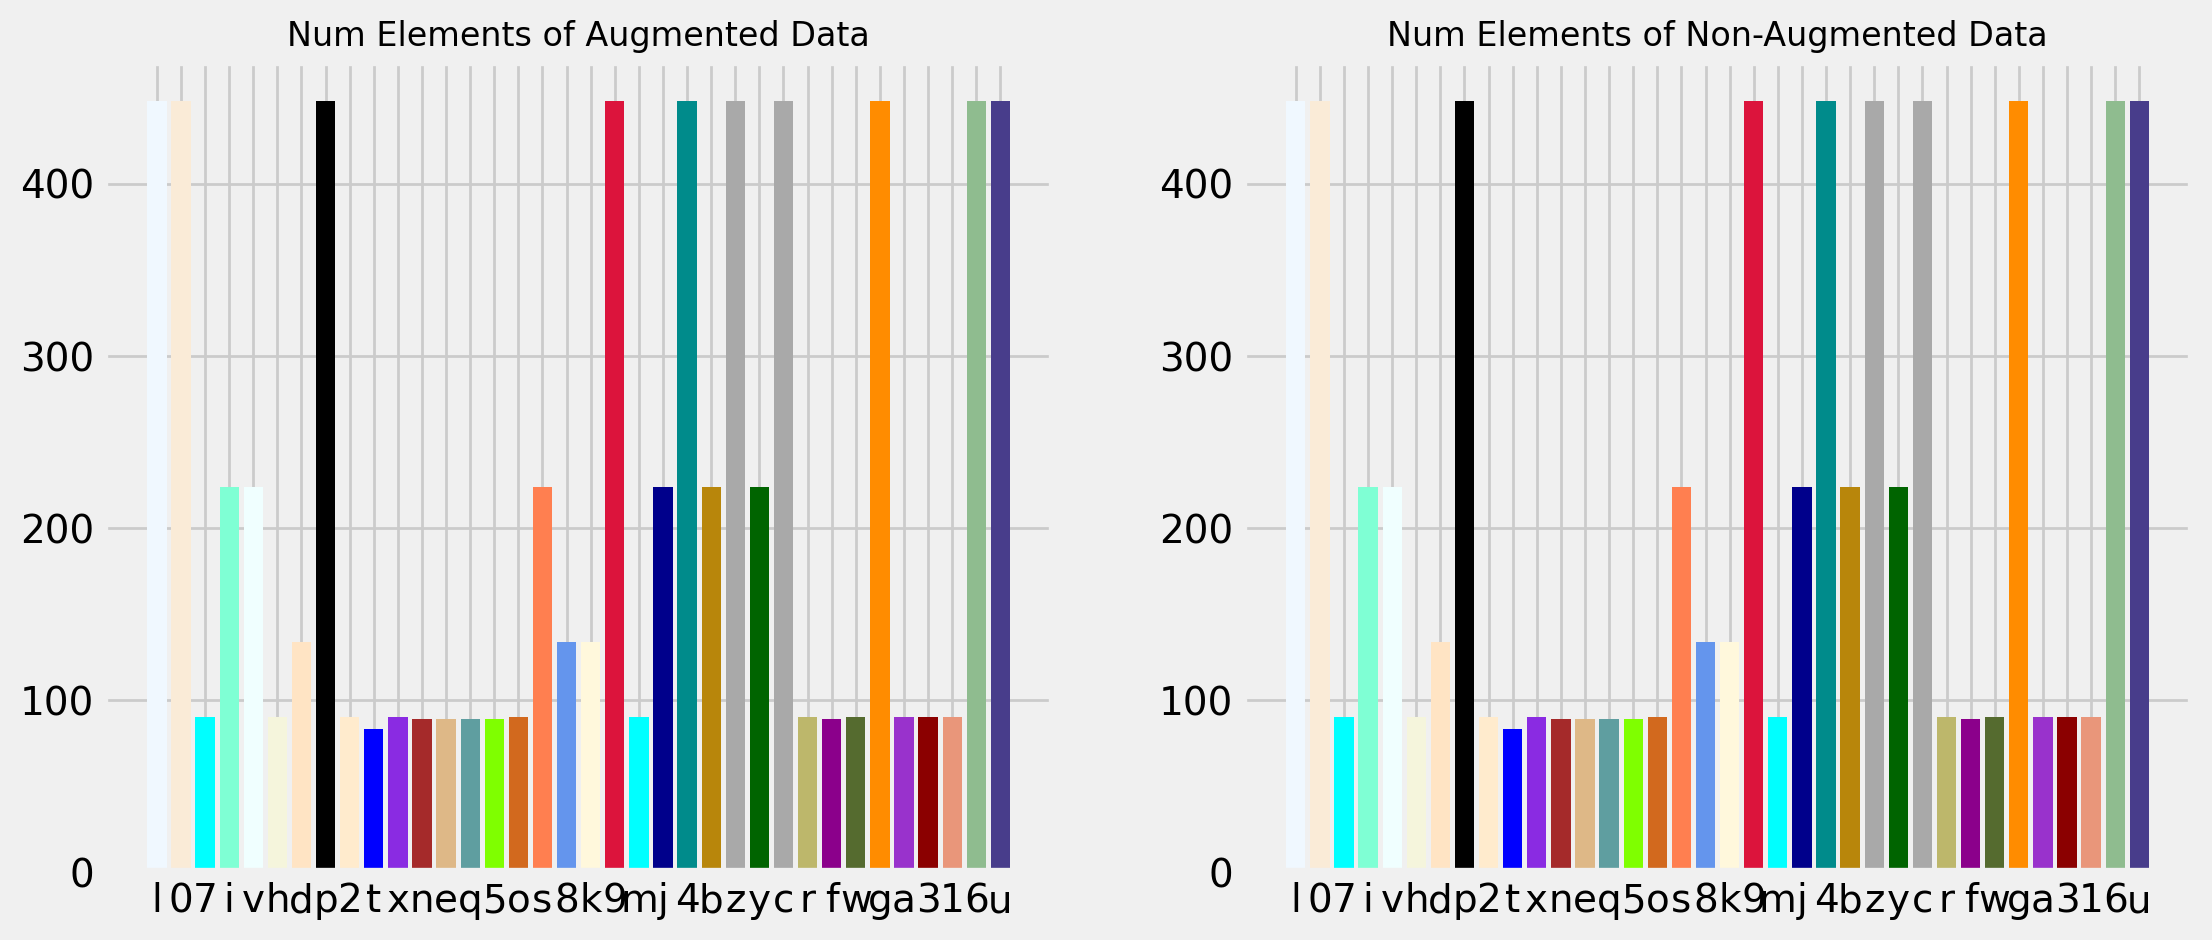

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200) 
ax[0].bar(range(num_classes), classes_aug_cups.values(), color=color_names, tick_label=classes)
ax[0].set_title("Num Elements of Augmented Data", fontsize=12)
ax[1].bar(range(num_classes), classes_naug_cups.values(), color=color_names, tick_label=classes)
ax[1].set_title("Num Elements of Non-Augmented Data", fontsize=12)
plt.show()

In [13]:
# create transform
img_transform = default_transform(IMG_HEIGHT, IMG_HEIGHT)

# train dataset was declared earlier
train_dataset = SignLanguageDataset(train_labels, img_dir=IMAGES_PATH, transform=img_transform)
test_dataset = SignLanguageDataset(annotations=test_labels, img_dir=IMAGES_PATH, transform=def_transform)

trainset_len = len(train_dataset)
testset_len = len(test_dataset)
total_len = train_dataset + test_dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Size-Dataset:   9680
Size-Test-Set:  1936
Size-Train-Set: 7744


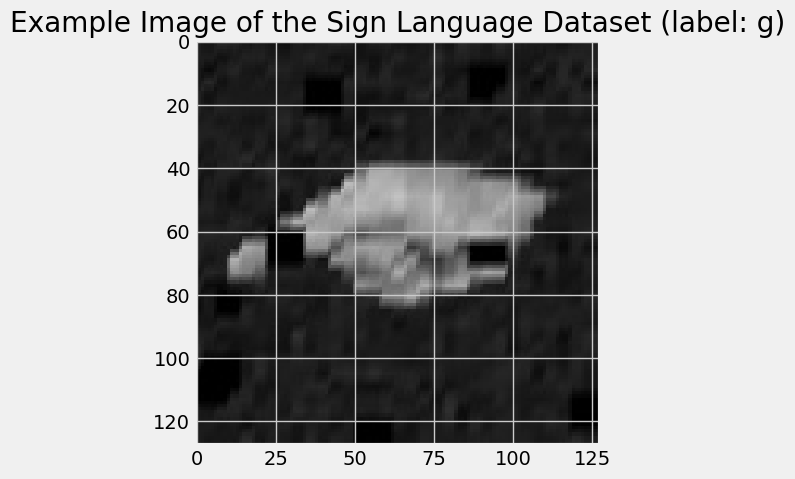

Shapes of DataLoader Items:
Batch-Size, Channels, Height, Width
[32, 3, 128, 128]


In [14]:
print(f"Size-Dataset:   {len(total_len)}", f"Size-Test-Set:  {testset_len}", f"Size-Train-Set: {trainset_len}", sep="\n")
# plot the image as example
image, label = train_dataset[304]
image = image.permute(1, 2, 0)
image = np.clip(image, 0.0, 1.0)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title("Example Image of the Sign Language Dataset (label: {})".format(label))
plt.show()

train_loader_iter = iter(train_loader)
samp = next(train_loader_iter)
shape_samp = samp[0].shape
print(f"Shapes of DataLoader Items:\nBatch-Size, Channels, Height, Width\n{list(shape_samp)}")

# Create the Neural Network Class

In [15]:
from torch import nn
import torch.nn.functional as F

class ConvSignLangNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 8, 5)
        self.fc1 = nn.Linear(8 * 29 * 29, 256)
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, num_classes)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) # ([32, 8, 29, 29])
        # 
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

## Training the model 

In [16]:
class_index = {label:idx for idx, label in enumerate(classes)}
index_class = {idx:label for idx, label in enumerate(classes)}

In [17]:
def label_to_int_index(label: str, class_index_dict: dict):
    return class_index_dict[label]

test_l = 'l'
assert label_to_int_index(test_l, class_index) == 0

In [18]:
def label_to_one_hot(label, labels):
    one_hot_label = [1 if label == cls else 0 for cls in labels]
    return one_hot_label

test_l = 'l'
one_hot_l = label_to_one_hot(test_l, classes)
assert one_hot_l[0] == 1

In [19]:
def train_batch(model: nn.Module, batch, optimizer: torch.optim.Optimizer, loss_function):
    # enable training
    model.train()
    img, tar = batch
    index_of_label = torch.tensor([label_to_int_index(t, class_index) for t in tar], dtype=torch.long)
    
    ## begin training
    optimizer.zero_grad()
    out = model(img)
    batch_loss = loss_function(out, index_of_label)
    batch_loss.backward()
    optimizer.step()
    
    return batch_loss.item()

In [20]:
def predict_hand_sign(model: torch.nn.Module, batch):
    """
    
    :param model: 
    :param batch: 
    :return: 
    """
    pass

In [21]:
def conv_idx_prediction_to_class(batch_predictions: np.ndarray, idx_class_dict: dict):
    """
    
    :param batch_predictions:  of which the _rows_ are the probabilities of a sample to belong to the specific class (at idx), _cols_ are samples (should be BATCH_SIZE columns)
    :param idx_class_dict: dictionary where a numerical value is mapped to its class, e.g. {0: "l", 1: "a", ...}
    :return: a list of length BATCH_SIZE 
    """
    class_predictions = []
    for smp_predictions in batch_predictions:
        final_prediction_num = np.argmax(smp_predictions)
        final_prediction = idx_class_dict[final_prediction_num]
        class_predictions.append(final_prediction)
        
    return class_predictions

In [22]:
model_0 = ConvSignLangNN()
optim = torch.optim.Adam(params=model_0.parameters(), lr = LR)
loss_fn_0 = torch.nn.CrossEntropyLoss()

In [23]:
from tqdm import tqdm
EPOCHS = 10
total_train_losses = []
total_test_losses = []
for epoch in range(EPOCHS):
    epoch_loss_train = []
    epoch_loss_test = []
    batch_nr = 0
    model_0.train()
    
    ## train and gather loss
    running_loss_train = 0
    for batch in tqdm(train_loader):
        feat, _ = batch
        loss = train_batch(model_0, batch, optim, loss_fn_0) # loss is already *.item()
        running_loss_train = running_loss_train + (loss * feat.size(0))
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    total_train_losses.append(epoch_loss_train)
    
    ## evaluate model on test set
    model_0.eval()
    running_loss_test = 0
    with torch.no_grad():
        for feat, tar in test_loader:
            out = model_0(feat)
            index_of_label = torch.tensor([label_to_int_index(t, class_index) for t in tar], dtype=torch.long)
            loss = F.cross_entropy(out, index_of_label)
            running_loss_test = running_loss_test + (loss * feat.size(0))
    
    epoch_loss_test = running_loss_test / len(test_loader.dataset)
    total_test_losses.append(epoch_loss_test)
    print(f"Epoch {epoch} done. | Loss = {epoch_loss_test}")
            

100%|██████████| 242/242 [00:40<00:00,  5.92it/s]


Epoch 0 done. | Loss = 2.718769073486328


100%|██████████| 242/242 [00:40<00:00,  6.00it/s]


Epoch 1 done. | Loss = 2.4289677143096924


100%|██████████| 242/242 [00:40<00:00,  6.00it/s]


Epoch 2 done. | Loss = 2.3665387630462646


100%|██████████| 242/242 [00:40<00:00,  6.00it/s]


Epoch 3 done. | Loss = 2.222075939178467


100%|██████████| 242/242 [00:40<00:00,  5.99it/s]


Epoch 4 done. | Loss = 2.202558994293213


100%|██████████| 242/242 [00:40<00:00,  5.99it/s]


Epoch 5 done. | Loss = 2.1958718299865723


100%|██████████| 242/242 [00:40<00:00,  6.02it/s]


Epoch 6 done. | Loss = 2.1785471439361572


100%|██████████| 242/242 [00:38<00:00,  6.23it/s]


Epoch 7 done. | Loss = 2.169468402862549


100%|██████████| 242/242 [00:40<00:00,  6.00it/s]


Epoch 8 done. | Loss = 2.235438585281372


100%|██████████| 242/242 [00:40<00:00,  5.95it/s]


Epoch 9 done. | Loss = 2.226207733154297


# Evaluate the model

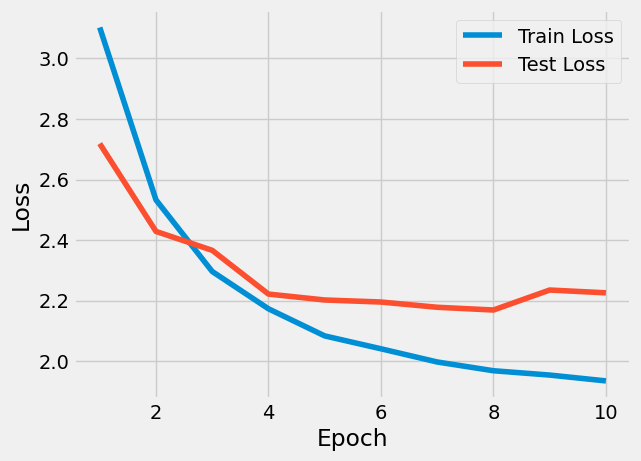

In [24]:
# total_losses_flat = [x for subl in total_train_losses for x in subl ]
plt.plot(range(1, EPOCHS+1), total_train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), total_test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
# Get a Test Batch
test_loader_iter = iter(test_loader)
test_img_batch, test_label_batch = next(test_loader_iter)

In [26]:
# predict classes of test batch
model_0.eval()
with torch.no_grad():
    pred_test_batch = model_0(test_img_batch)
prob_preds_np = pred_test_batch.numpy()

class_predictions = conv_idx_prediction_to_class(prob_preds_np, index_class) 

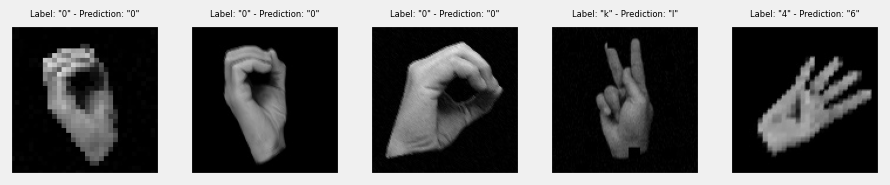

In [27]:
start_img = 10 
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    ax_img = test_img_batch[start_img+i]
    ax_img = ax_img.permute(1, 2, 0)
    ax[i].imshow(ax_img)
    ax[i].grid(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title("Label: \"{}\" - Prediction: \"{}\"".format(test_label_batch[start_img + i],
                                                                class_predictions[start_img + i]),
                    fontsize=6)

## Get the accuracy of the model

In [28]:
# set to evaluation mode
model_0.eval()

batches_predictions = []
batches_labels = []
with torch.no_grad():
    for img, label in test_loader:
        batch_preds = model_0(img).numpy()
        batch_preds = conv_idx_prediction_to_class(batch_preds, index_class)
        batches_predictions.append(batch_preds)
        batches_labels.append(list(label))

In [29]:
# unwind the sublist of the batches
batches_predictions = [x for sub in batches_predictions for x in sub]
batches_labels =[ x for sub in batches_labels for x in sub]

correct_test_samples = 0
total_test_samples = 0
for bp, bl in zip(batches_predictions, batches_labels):
    if bp == bl:
        correct_test_samples += 1
    total_test_samples += 1

accuracy = (correct_test_samples / total_test_samples)
print(f"> The total accuracy of the model is: {accuracy:.2f}.\n")

> The total accuracy of the model is: 0.44.


# Summary

In [30]:
from datetime import datetime
binds = 70
date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("## ", date)
print()
print("-"*binds)
print("- Total Samples:", trainset_len + testset_len, "\n- Samples used for Training:", trainset_len,"\n- Samples used for Testing:", testset_len, f"\n- Train-Size (\%): {TRAIN_SIZE}")
print("-"*binds)
print(f"- {correct_test_samples}/{total_test_samples} were predicted correctly\n- Resulting in an accuracy of {accuracy*100:.2f}%")
print("-"*binds)
print("Hyperparameters:")
print(f"- Batch-Size: {BATCH_SIZE}", f"Epochs: {EPOCHS}", f"Learning-Rate: {LR}", sep="\n- ")
print("-"*binds)
print("Model:\n```\n", model_0,"\n```")
summary = f"## {date}\n\n"

##  2024-07-31 12:30:11

----------------------------------------------------------------------
- Total Samples: 9680 
- Samples used for Training: 7744 
- Samples used for Testing: 1936 
- Train-Size (\%): 0.8
----------------------------------------------------------------------
- 860/1936 were predicted correctly
- Resulting in an accuracy of 44.42%
----------------------------------------------------------------------
Hyperparameters:
- Batch-Size: 32
- Epochs: 10
- Learning-Rate: 0.001
----------------------------------------------------------------------
Model:
```
 ConvSignLangNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6728, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linea

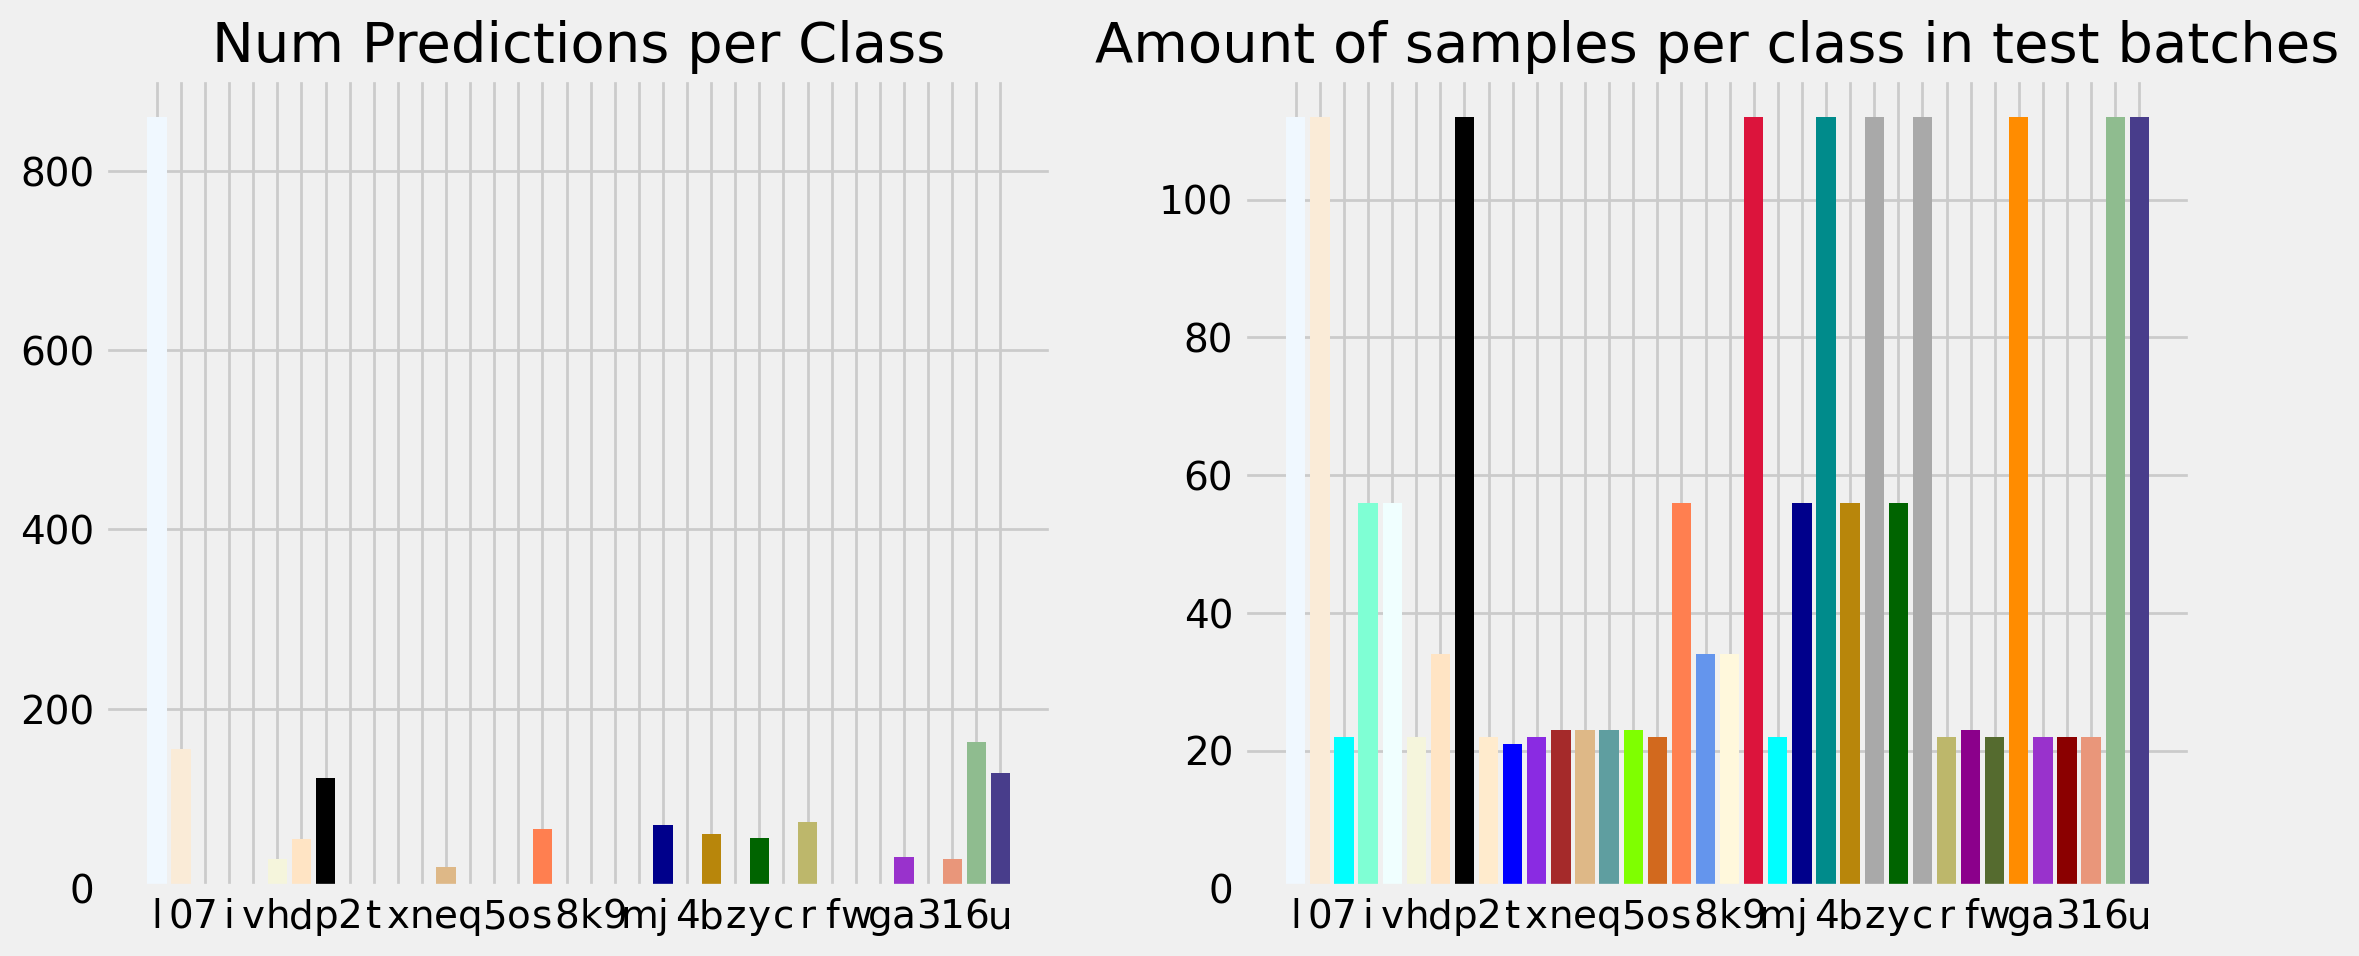

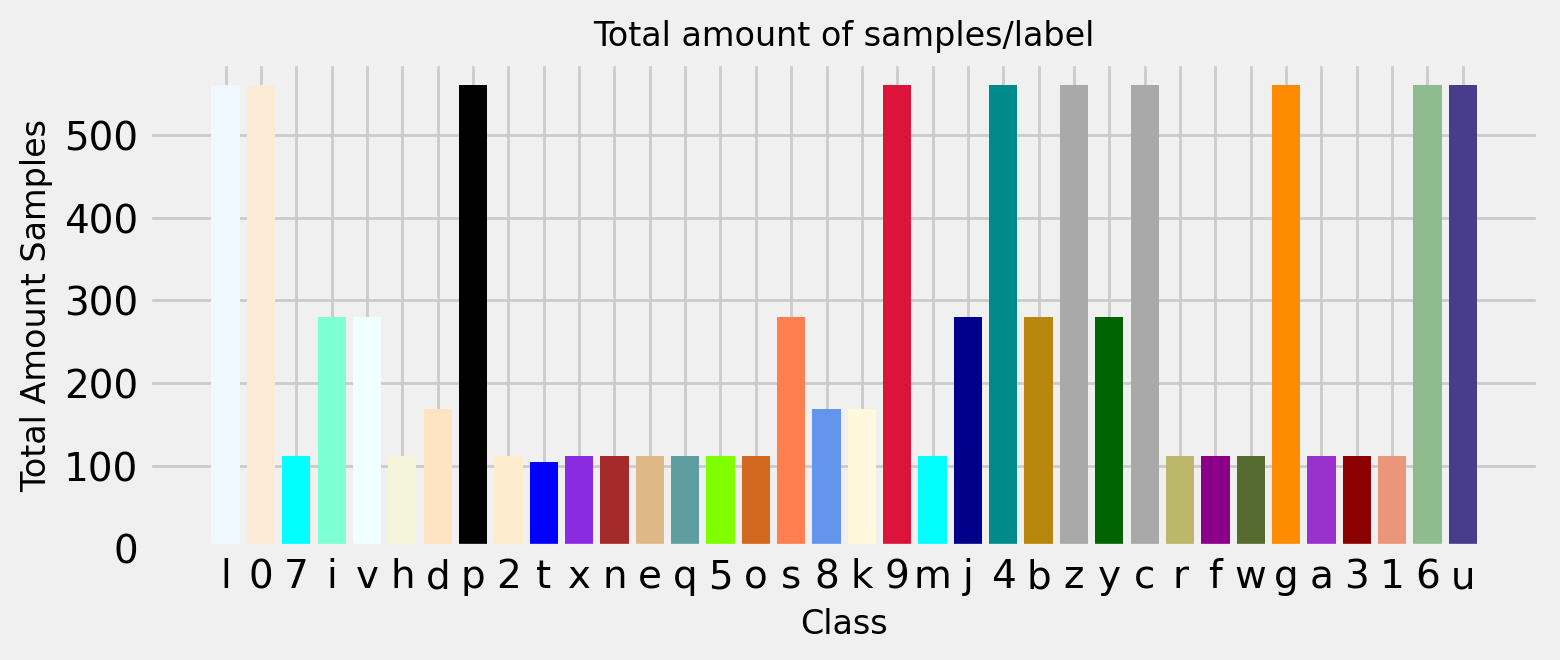

In [31]:
# batches_predictions
pred_per_class = {cls:0 for cls in classes}
num_labels_test = {cls:0 for cls in classes}
for _, label in test_loader:
    for l in label:
        num_labels_test[l] += 1
# get how many times the model predicted a certain class
for bp in batches_predictions:
    pred_per_class[bp] += 1

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax[0].bar(range(num_classes), pred_per_class.values(), tick_label = list(pred_per_class.keys()), color=color_names)
ax[0].set_title("Num Predictions per Class")

ax[1].bar(range(num_classes), num_labels_test.values(), tick_label = list(num_labels_test.keys()), color=color_names)
ax[1].set_title("Amount of samples per class in test batches")

plt.show()

plt.figure(figsize=(8, 3), dpi=200)
plt.title("Total amount of samples/label", fontsize=12)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Total Amount Samples", fontsize=12)
plt.bar(range(num_classes), class_values, tick_label = classes, color=color_names)
plt.show()
